In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 split
from sklearn.model_selection import train_test_split

# 회귀분석
import statsmodels.formula.api as smf
import statsmodels.formula.api as ol

from sklearn.tree import DecisionTreeRegressor
# 앙상블 모델
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.model_selection import GridSearchCV

# 평가함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

# 폰트 설정
matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percenatage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) *  100

In [3]:
df_raw = pd.read_csv("./Data_OTT_update/customer.csv", engine="python")

# 데이터 전처리

In [4]:
df_raw.drop("customer_id", axis=1, inplace=True) 
df_raw.drop('download_count', axis=1, inplace = True)
df_raw.drop('class', axis = 1, inplace = True)
df_raw.drop('area', axis = 1, inplace = True)
df_raw

,gender,age,age_group,married,kids_under12,subs_start_year,total_price
0,F,51,50,1,0,2015,262000.0
1,M,22,20,0,0,2015,102200.0
2,F,33,30,1,1,2015,270800.0
3,F,24,20,1,0,2015,200400.0
4,F,35,30,1,0,2015,165900.0
...,...,...,...,...,...,...,...
3272,F,43,40,1,0,2018,37000.0
3273,F,24,20,1,0,2018,48700.0
3274,F,55,50,0,0,2018,44500.0
3275,F,36,30,0,1,2018,77500.0


total_price = 고객 데이터에서 다운로드 횟수를 묶어 고객이 다운로드한 데이터의 가격을 계산한 컬럼

In [5]:
change_fm = {"M": 1, "F": 0}
df_raw = df_raw.replace({'gender': change_fm})

기존에 M, F 범주형으로 묶여있던 성별 컬럼을 남자면 1, 여자면 0 이렇게 연속형 변수로 변경

In [6]:
df_raw.head()

,gender,age,age_group,married,kids_under12,subs_start_year,total_price
0,0,51,50,1,0,2015,262000.0
1,1,22,20,0,0,2015,102200.0
2,0,33,30,1,1,2015,270800.0
3,0,24,20,1,0,2015,200400.0
4,0,35,30,1,0,2015,165900.0


In [7]:
# X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random state= random seed
df_raw_y = df_raw["total_price"] # 목표변수
df_raw_x = df_raw.drop("total_price", axis=1, inplace=False) # 설명변수

# get_dummies : 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw_x)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
display(df_raw_dummy.head())
display(df_raw.info())

# train 데이터 0.6, test 데이터 0.4로 분할
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_dummy, df_raw_y, test_size=0.4)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

,gender,age,age_group,married,kids_under12,subs_start_year
0,0,51,50,1,0,2015
1,1,22,20,0,0,2015
2,0,33,30,1,1,2015
3,0,24,20,1,0,2015
4,0,35,30,1,0,2015


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           3277 non-null   int64  
 1   age              3277 non-null   int64  
 2   age_group        3277 non-null   int64  
 3   married          3277 non-null   int64  
 4   kids_under12     3277 non-null   int64  
 5   subs_start_year  3277 non-null   int64  
 6   total_price      3277 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 179.3 KB


None

train data X size: (1966, 6)
train data Y size: (1966,)
test data X size: (1311, 6)
test data Y size: (1311,)


고객이 원하는 컨텐츠 1건을 다운로드할 때마다 생기는 비용으로 수익을 창출하는 구조이기 때문에, \
고객이 다운로드한 데이터 누적 계산 비용이 좋은 영화사의 수익률을 높일 수 있는 지표라고 생각했고 이를 통해 목표변수로 설정하게 됨.

In [8]:
strings = "+".join(list(df_train_x.columns))

In [9]:
strings

'gender+age+age_group+married+kids_under12+subs_start_year'

In [10]:
# 회귀모델
lr_model = smf.ols(formula = "total_price ~ " + strings, data = df_raw)
lr_result = lr_model.fit()
print(lr_result.summary())

                            OLS Regression Results                            
Dep. Variable:            total_price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1952.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:22:20   Log-Likelihood:                -39648.
No. Observations:                3277   AIC:                         7.931e+04
Df Residuals:                    3270   BIC:                         7.935e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.313e+08   1.41e+06     

목표변수 total_price로 정하고, 그 외의 변수들을 설명변수로 정하고 회귀분석한 결과 설명력이 0.782로 출력이 되는 것을 확인했습니다.

In [11]:
# Decision Tree 모델
dt_model = DecisionTreeRegressor(min_samples_leaf=14, min_samples_split=32, max_depth=7)
dt_model.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(dt_model.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(dt_model.score(df_test_x, df_test_y)))

Score on training set: 0.837
Score on test set: 0.822


목표변수 total_price로 정하고, 그 외의 변수들을 설명변수로 정하고 의사결정나무를 모델링한 결과 설명력이 0.813으로 출력이 되는 것을 확인했습니다.

In [12]:
# RandomForest 모델
rf_model = RFR(n_estimators=50, min_samples_leaf=9,
                               min_samples_split=17, max_depth=8)
rf_model.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_model.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(rf_model.score(df_test_x, df_test_y)))

Score on training set: 0.842
Score on test set: 0.825


목표변수 total_price로 정하고, 그 외의 변수들을 설명변수로 정하고 랜덤포레스트를 모델링한 결과 설명력이 0.817로 출력이 되는 것을 확인했습니다.

In [13]:
# Gradient Boosting 모델
gb_model = GBR(n_estimators=80, min_samples_leaf=14, max_depth=6, learning_rate=0.1)
gb_model.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(gb_model.score(df_train_x, df_train_y)))

#test데이터 설명력
print("Score on test set: {:.3f}".format(gb_model.score(df_test_x, df_test_y)))

Score on training set: 0.850
Score on test set: 0.820


목표변수 total_price로 정하고, 그 외의 변수들을 설명변수로 정하고 그래디언트 부스팅 모델을 모델링한 결과 설명력이 0.816으로 출력이 되는 것을 확인했습니다.

그리고 모든 모델링 결과 변수 중요도가 sub_start_year (고객의 구독 시작년도), kids_under12(12세 미만 어린이 고객), area_송파구(송파구 지역 고객), age(고객 나이) 순으로 분포되는 것을 확인할 수 있었습니다.\
이를 토대로 우리는 좋은 영화사와 total_price에 연관된 중요 변수를 도출하여 total_price에 대한 연관성을 파악할 수 있었습니다.

## 3. 예측 및 평가

### 예측 평가 리스트 생성

In [14]:
# 모델 리스트, 그래프를 그리기 위한 생성 목적
models=["Linear", "Decision Tree", "Random Forest", "Gradient Boosting"]

# 평가 리스트 초기화
mse, rmse, mae, mape = [], [], [], []

1) Regression

In [15]:
lr_y_pred = lr_result.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, lr_y_pred))
rmse.append(root_mean_squared_error(df_test_y, lr_y_pred))
mae.append(mean_absolute_error(df_test_y, lr_y_pred))
mape.append(mean_absolute_percenatage_error(df_test_y, lr_y_pred))

2) Decision Tree

In [16]:
dt_y_pred = dt_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percenatage_error(df_test_y, dt_y_pred))

3) Random Forest

In [17]:
rf_y_pred = rf_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percenatage_error(df_test_y, rf_y_pred))

4) Grdient Boosting

In [18]:
gb_y_pred = gb_model.predict(df_test_x)

mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percenatage_error(df_test_y, gb_y_pred))

In [19]:
print(mape)

[25.817839408401355, 19.51068016211926, 19.452816546821204, 19.700317290724016]


### 평가 시각화

Text(0.5, 1.0, 'mape')

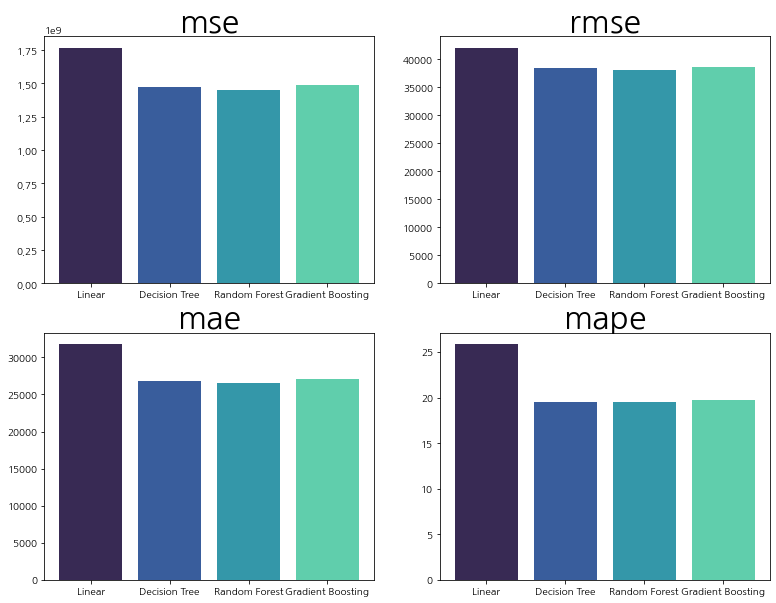

In [22]:
## 그래프 커스터 마이징
colors = sns.color_palette('mako', 4)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (13, 10))

ax[0, 0].bar(models, mse, color=colors)
ax[0, 0].set_title("mse", fontsize = 32)

ax[0, 1].bar(models, rmse, color=colors)
ax[0, 1].set_title("rmse", fontsize = 32)

ax[1, 0].bar(models, mae, color=colors)
ax[1, 0].set_title("mae", fontsize = 32)

ax[1, 1].bar(models, mape, color=colors)
ax[1, 1].set_title("mape", fontsize = 32)

- Regression 모델이 모든 평가 지표에서 가장 점수가 낮게 나왔기에 성능이 가장 좋다고 할 수 있다. 반면에 Decision Tree모델의 성능이 가장 좋지 않다고 할 수 있다. 평가지표별 모델의 정확도 "추세"는 동일하게 나타난다.

이 모델링을 통해서는 매출에 영향을 줄 수 있는 세분화된 고객 특성 인자 - 고객의 구독 시작년도, 12세 미만, 송파구 주민 고객, 고객의 나이를 도출할 수 있었습니다. \ 

- 고객 기반(목표변수: 누적 금액): 고객 기반 모델링 결과 판매액에 영향을 미치는 요인으로 married, under_12 등이 나왔다.  --> 추후 마케팅 등을 진행할 때 핵심 타겟층으로 지정하거나, 해당 특성을 가진 고객들의 선호장르를 고려해서 판권 구매 \
- 영화 데이터 기반(목표변수: 총 판매액): 여러 모델링 결과 유의미한 특성을 발견할 수 없음. --> 우리 회사의 매출은 영화의 개별 인자보다는, 고객들의 선호도에 더 큰 영향을 받는다고 해석 -->   따라서 개별 고객들의 선호도를 반영한 추천 알고리즘의 개발 필요